In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os.path as osp
import pickle
from collections import defaultdict
import seaborn as sns
import os
from IPython.display import Markdown

/home/aszot/miniconda3/envs/tor/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


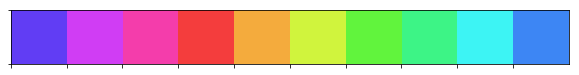

In [2]:
colors = sns.hls_palette(n_colors=10, l=0.6, s=.9, h=0.7)
sns.palplot(colors)

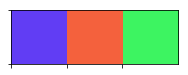

In [3]:
full_colors = sns.hls_palette(n_colors=3, l=0.6, s=.9, h=0.7)
sns.palplot(full_colors)

In [74]:
g_common_name_map = {
    'main': 'Full',
    'main2': 'Full (state)',
    'tvae': 'VAE',
    'vae': 'VAE',
    'dist': 'Dist',
    'rnd_sample': 'RS',
    'rs': 'RS',
    'no_ent': 'NE',
    'ne': 'NE',
    'nn': 'NN',
    'fixed': 'FX',
    'fix': 'FX',
    'ac_fixed': 'FX',
    'fx': 'FX',
    'gt': 'GT',
    'im': 'Full (image)',
    'all': 'All',
    
    'funnel': 'Funnel',
    'basket': 'Basket',
    'ladder': 'Ladder',
    'moving': 'Moving',
    'collide': 'Collide',
    'cannon': 'Cannon',
    'buckets': 'Buckets',
    'belt': 'Belt',
    'navigate': 'Navigate',
    
    'full': 'Full Split',
    'dim0': 'No Place',
    'dim2': '2D Place',
}

g_common_color_map = {
    'Full':  colors[3],
    'NE':    colors[0],
    'RS':    colors[1],
    'FX': colors[2],
    
    'GT': colors[4],
    'Full (state)': colors[5],
    'Full (image)':    colors[5],
    'All': colors[6],
    
    # Greens 
    'VAE': colors[7],
    'Dist': colors[8],
    'NN': colors[9],
    
    'Full Split': colors[4],
    'No Place': colors[0],
    '2D Place': colors[6],
    
    'push': full_colors[0],
    'obstacle': full_colors[1],
    'seesaw': full_colors[2],
    
    'Funnel' : colors[0],
    'Basket': colors[1],
    'Ladder': colors[2],
    'Moving': colors[3],
    'Collide': colors[4],
    'Cannon': colors[5],
    'Buckets': colors[6],
    'Belt': colors[7],
    'Navigate': colors[8],
}
def_ordering = [
    'main', 
    'rnd_sample', 'rs', 
    'no_ent', 'ne',
    'ac_fixed', 'fixed', 'fx',
    'tvae', 'vae',
    'gt', 'dist', 'nn',
    'im', 'main2', 'all',

    'funnel',
    'basket',
    'ladder',
    'moving',
    'collide',
    'cannon',
    'buckets',
    'belt',
    'navigate',

    'dim0',
    'dim2',
    'full',
   ]


ablation_names = [
    'main',
    'no_ent',
    'ac_fixed', 'fixed', 'fx'
]

baseline_names = [
    'main',
    'tvae', 'vae', 
    'dist', 
    'nn',
]


oracle_names = [
    'main',
    'im', 'main2',
    'gt',
    'all'
]

def extract_data(dat, scale=100.0):
    names = []
    results = []
    
    for k in def_ordering:
        if k in dat:
            names.append(k)
            results.append(dat[k])
    for k, v in dat.items():
        if k not in def_ordering:
            names.append(k)
            results.append(v)
    results = [np.array(x) * scale for x in results]
    return results, names

def load_datas(result_names, ret_train=False, scale=100.0, replace=False, early_ret=False):
    d = defaultdict(list)
    for result_name in result_names:
        dat, names = load_data(result_name, ret_train, scale)
        for i, n in enumerate(names):
            if replace:
                d[n] = list(dat[i])
            else:
                d[n].extend(list(dat[i]))
    
    for n in d:
        d[n] = np.array(d[n])
    if early_ret:
        vn_pairs = list([(k, d[k]) for k in d])
        return [x[1] for x in vn_pairs], [x[0] for x in vn_pairs]
        
    vn_pairs = list([(k, d[k]) for k in def_ordering if k in d])
    return [x[1] for x in vn_pairs], [x[0] for x in vn_pairs]

x = load_datas

def load_data(result_name, ret_train=False, scale=100.0):
    full_path = osp.join('/home/aszot/functional-rl/analysis/outcomes/', result_name + '.o')
    with open(full_path, 'rb') as f:
        results_train, results_test = pickle.load(f)
    if ret_train:
        ret_val = results_train
    else:
        ret_val = results_test
    if ret_val is None or len(ret_val) == 0:
        return [], []
        
    first_ele = ret_val[list(ret_val.keys())[0]][0]
    if isinstance(first_ele, tuple):
        for k in ret_val:
            ret_val[k] = [x[1] for x in ret_val[k]]
    return extract_data(ret_val, scale=scale)
        

def plot_bar(y_vals_1, y_vals_2, method_names, y_name, title, scaling=100.0, show_axis=False, 
             x_size_factor=1.5):
    """
    y_vals_1: Bars to be plotted in the front
    y_vals_2: Bars to be plotted in the back
    """
    method_names = [g_common_name_map[x] if x in g_common_name_map else x for x in method_names]
    y_1_mean = [np.mean(y) for y in y_vals_1]
    y_1_std = [np.std(y) for y in y_vals_1]
    
    y_2_mean = [np.mean(y) for y in y_vals_2]
    y_2_std = [np.std(y) for y in y_vals_2]
    method_colors = [g_common_color_map[x] for x in method_names]
    hatches = ['','/','\\','-', '.']
    if 'GT' in method_names:
        hatches = ['', '-', '/', '\\']
    
    pos_end = 0.25 * len(method_names)
    y_pos = np.arange(0, pos_end, pos_end / len(method_names))
#     bar_width = (pos_end / len(method_names)) * 0.8
    bar_width = 0.25 * 0.8
    bar_darkness = 0.2
    plt.rcParams["figure.figsize"] = ((len(method_names) + 1) * x_size_factor,5)
    
    bars = plt.bar(y_pos, y_2_mean, align='center', alpha=0.25, color=method_colors, yerr=y_2_std, 
            width=bar_width, 
            error_kw=dict(ecolor=(0.5, 0.5, 0.5, 0.5), lw=2, capsize=2, capthick=2))
    bars = plt.bar(y_pos, y_1_mean, align='center', alpha=0.8, color=method_colors, yerr=y_1_std,
            edgecolor=(0, 0, 0, 1.0),
            linewidth=2,
            width=bar_width,
            error_kw=dict(ecolor=(bar_darkness, bar_darkness, bar_darkness, 1.0), lw=2, capsize=3, capthick=2))
    for bar, pattern in zip(bars, hatches):
        bar.set_hatch(pattern)
        
#     for bar, pattern in zip(bars, hatches):
#         bar.set_hatch(pattern)
    
    plt.xticks(y_pos, ['' for x in method_names], fontsize=16)
    if show_axis:
        plt.xticks(y_pos, method_names, fontsize=16)
    if scaling is not None:
        plt.ylim(0, scaling)
    plt.ylabel(y_name, fontsize=18)
    plt.title(title, fontsize=22)

    #plt.show()
    
    
def save_fig(filename, file_format='pdf', tight=True, **kwargs):
    if tight:
        plt.tight_layout()
    filename = filename.replace(' ', '_').lower()
    print('saved to ', filename)
    plt.savefig("/home/aszot/functional-rl/data/figures/{}.{}".format(filename, file_format), format=file_format, dpi=1000, **kwargs)
    
def extract_ref_plot(vals_1, vals_2, names, ref_names, y_name, title, scaling=100.0, **kwargs):
    use_vals_1 = [val for val, name in zip(vals_1, names) if name in ref_names]
    use_vals_2 = [val for val, name in zip(vals_2, names) if name in ref_names]
    
    plot_bar(
        use_vals_1, 
        use_vals_2, 
        [n for n in names if n in ref_names], y_name, title, scaling, **kwargs)
    

In [77]:
def generate_all(train_methods, test_methods, task_name, load_name=None, 
                 py='Success Rate (%)', scale=[110.0] * 3, data_scale=100.0, replace=True, use_width=1.0, add_dat=None):
    if load_name is None:
        load_name = task_name
    train_methods = [load_name.lower() + '/' + x for x in train_methods]
    test_methods = [load_name.lower() + '/' + x for x in test_methods]
    
    train_vals, method_names = load_datas(train_methods, replace=replace, ret_train=True, scale=data_scale)
    test_vals, method_names = load_datas(test_methods, replace=replace, ret_train=False, scale=data_scale)
    
    def combine(x, d):
        for i, m in enumerate(method_names):
            if m in d:
                x[i] = list(x[i])
                x[i].extend(d[m])
                x[i] = np.array(x[i])
        return x
    
    if add_dat is not None:
        train_vals = combine(train_vals, add_dat['train'])
        test_vals = combine(test_vals, add_dat['test'])
        
    debug_axis=False

    extract_ref_plot(test_vals, train_vals, method_names, baseline_names, py, 
                     task_name, 
                     scale[0], x_size_factor=use_width, show_axis=debug_axis)
    save_fig(task_name + '_baselines')
    plt.clf()
    
    extract_ref_plot(test_vals, train_vals, method_names, ablation_names, py, 
                     task_name, 
                     scale[1], x_size_factor=use_width, show_axis=debug_axis)
    save_fig(task_name + '_ablations')
    plt.clf()
    
    if 'Seesaw' in task_name:
        use_oracle_names = [
                'main',
                'im', 'main2',
                'all'
            ]
    else:
        use_oracle_names = oracle_names
    extract_ref_plot(test_vals, train_vals, method_names, use_oracle_names, py, 
                     task_name, 
                     scale[2], x_size_factor=use_width, show_axis=debug_axis)
    save_fig(task_name + '_oracle')
    plt.clf()
    return train_vals, test_vals, method_names
    
    
def generate_reco(train_methods, test_methods, task_name, load_name=None, 
                 py='Success Rate (%)', scale=[0.5] * 3, trans_f=lambda x: x, 
                  override_title=None, plot_all=False, use_width=1.0):
    if load_name is None:
        load_name = task_name
    train_methods = [load_name.lower() + '/' + x for x in train_methods]
    test_methods = [load_name.lower() + '/' + x for x in test_methods]
    
    train_vals, method_names = load_datas(train_methods, replace=True, ret_train=True, scale=1.0)
    test_vals, method_names = load_datas(test_methods, replace=True, ret_train=False, scale=1.0)
    GW_WIDTH = 1.0
    debug_axis=False
    
    baseline_ctr = 0.15
    
    if trans_f is None:
        def trans(xs):
            for x in xs:
                diff = x - baseline_ctr
                per = diff / baseline_ctr
                yield per * 100.0
        trans_f = trans
    
    train_vals = list(trans_f(train_vals))
    test_vals = list(trans_f(test_vals))
    
    if plot_all:
        extract_ref_plot(test_vals, train_vals, method_names, [*baseline_names, *ablation_names[1:]], py, 
                     task_name, 
                     scale[0], x_size_factor=use_width, show_axis=debug_axis)
        save_fig(task_name)
    else:  
        baselines_title, ablations_title = task_name, task_name
        if override_title is not None:
            baselines_title, ablations_title = override_title

        extract_ref_plot(test_vals, train_vals, method_names, baseline_names, py, 
                         baselines_title, 
                         scale[0], x_size_factor=use_width, show_axis=debug_axis)
        save_fig(task_name + '_baselines')
        plt.clf()

        extract_ref_plot(test_vals, train_vals, method_names, ablation_names, py, 
                         ablations_title, 
                         scale[1], x_size_factor=use_width, show_axis=debug_axis)
        save_fig(task_name + '_ablations')
        plt.clf()

In [79]:
# Main Results
generate_reco(['reco_train'], ['reco_test'], 'Recommender', 'reco', 'CTR')
generate_all(['push_train', 'push_im_train'], ['push_test', 'push_im_test'], 'CREATE Push', 'Push')
generate_all(['seesaw_train'], ['seesaw_test'], 'CREATE Seesaw', 'Seesaw')
generate_all(['obstacle_train'], ['obstacle_test', 'obstacle_im_test'], 'CREATE Obstacle', 'Obstacle')
generate_all(['gw_train'], ['gw_test'], 'Grid World', 'gw')

saved to  recommender_baselines
saved to  recommender_ablations
saved to  create_push_baselines
saved to  create_push_ablations
saved to  create_push_oracle
saved to  create_seesaw_baselines
saved to  create_seesaw_ablations
saved to  create_seesaw_oracle
saved to  create_obstacle_baselines
saved to  create_obstacle_ablations
saved to  create_obstacle_oracle
saved to  grid_world_baselines
saved to  grid_world_ablations
saved to  grid_world_oracle


([array([91.47023572, 90.71670992, 90.5       , 89.89010989, 90.42574455,
         88.08      , 91.84489306, 89.81426004, 91.06536078]),
  array([81.52369526, 85.88822355, 89.57251298, 90.52947053, 85.94562175,
         89.21940507, 78.58      ]),
  array([99.92007992, 99.74015591, 99.78013192, 99.24136554, 99.80003999,
         99.62083416, 99.94027474, 99.48062325]),
  array([69.53919808, 70.73511786, 70.14180148, 69.78230477, 68.60511591,
         70.82917083]),
  array([96.08313349, 96.12310152, 95.52268639, 95.54      , 94.3       ,
         95.68776203, 95.52268639, 95.02      ]),
  array([19.9880072 , 14.23146112, 27.56346192, 22.32428115,  0.03997601,
         34.73915651, 25.53403873, 13.31467413]),
  array([99.78026368, 99.82050259, 99.58075464, 99.30097863, 99.84      ,
         99.82014388, 99.60087807, 99.36089475]),
  array([94.36338197, 92.2246652 , 92.38      , 93.30535572, 93.30669331,
         93.06693307, 92.12944467, 93.96603397]),
  array([93.72877971, 93.34798242,

<Figure size 288x360 with 0 Axes>

In [84]:
# Additional results
all_load = ['rebutt_nn_all', 'rebutt_no_ent_all', 'rebutt_fix_all', 'rebutt_dist_all', 'lg_add']
test_vals, method_names = load_datas([x + '_test' for x in all_load], 
                                     replace=False, ret_train=False, scale=100.0, early_ret=True)
train_vals, method_names = load_datas([x + '_train' for x in all_load], 
                                      replace=False, ret_train=True, scale=100.0, early_ret=True)

train_plot_groups = defaultdict(lambda: ([], []))
test_plot_groups = defaultdict(lambda: ([], []))
for test_val, train_val, name in zip(test_vals, train_vals, method_names):
    task_name = name.split('_')[-1]
    method_name = '_'.join(name.split('_')[:-1])
    method_name = method_name.replace('-', '_')
    if task_name == 'navivate':
        task_name = 'navigate'
    if method_name == '':
        method_name = 'main'
    train_plot_groups[task_name][0].append(train_val)
    train_plot_groups[task_name][1].append(method_name)
    
    test_plot_groups[task_name][0].append(test_val)
    test_plot_groups[task_name][1].append(method_name)
    
name_order = ['main', 'nn', 'no_ent', 'fix', 'dist']  
for task in test_plot_groups:
    test_vals = {k: v for v, k in zip(*test_plot_groups[task])}
    train_vals = {k: v for v, k in zip(*train_plot_groups[task])}
    
    extract_ref_plot([test_vals[k] for k in name_order], 
                     [train_vals[k] for k in name_order], name_order, name_order, 'Success Rate (%)', 
             'CREATE %s' % task.capitalize(), 110.0, x_size_factor=1.0, show_axis=False)
    save_fig('create_add_' + task)
    plt.clf()

saved to  create_add_navigate
saved to  create_add_belt
saved to  create_add_buckets
saved to  create_add_cannon
saved to  create_add_collide
saved to  create_add_moving
saved to  create_add_ladder
saved to  create_add_basket
saved to  create_add_funnel


<Figure size 432x360 with 0 Axes>

saved to  recommender_fully_observable


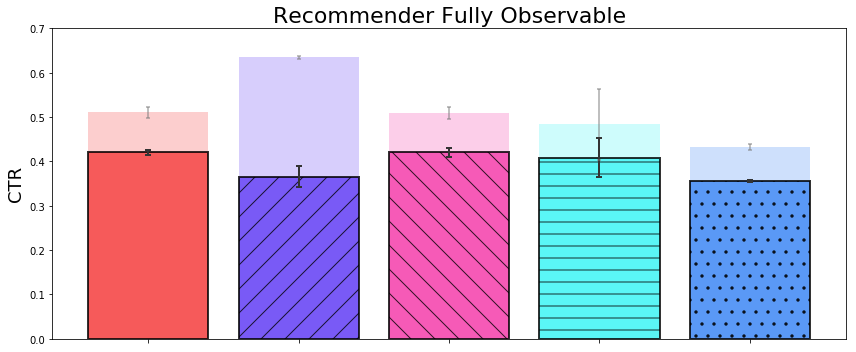

In [82]:
generate_reco(['reco_new_train'], ['reco_new_test'], 'Recommender Fully Observable',  
              'reco', 'CTR', scale=[0.7] * 2, plot_all=True, use_width=2.0)

saved to  stack_additional


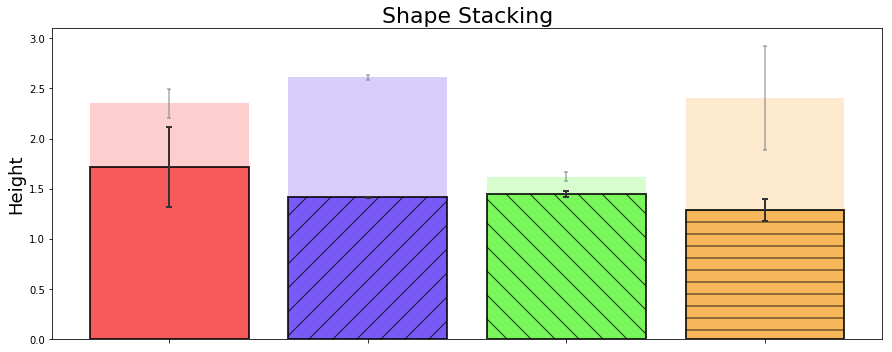

In [81]:
add_dat = {
    'train': {
    },
    'test': {
    }
}

all_runs = ['bs/' + x.split('.')[0] for x in os.listdir('../analysis/outcomes/bs')]
train_methods = [x for x in all_runs if 'train' in x]
test_methods = [x for x in all_runs if 'test' in x]

train_vals, method_names = load_datas(train_methods, replace=False, ret_train=True, scale=1.0)
test_vals, method_names = load_datas(test_methods, replace=False, ret_train=False, scale=1.0)

keep_methods = ('main', 'full', 'dim0', 'dim2')
# train_vals = [vals for name, vals in zip(method_names, train_vals) if name in keep_methods]
# test_vals = [vals for name, vals in zip(method_names, test_vals) if name in keep_methods]
# method_names = [x for x in method_names if x in keep_methods]
# print(method_names)

def combine(x, d):
    for i, m in enumerate(method_names):
        if m in d:
            x[i] = list(x[i])
            x[i].extend(d[m])
            x[i] = np.array(x[i])
    return x

if add_dat is not None:
    train_vals = combine(train_vals, add_dat['train'])
    test_vals = combine(test_vals, add_dat['test'])


extract_ref_plot(test_vals, train_vals, method_names, keep_methods, 'Height', 
                 'Shape Stacking', 
                 3.1, x_size_factor=2.5, show_axis=False)
save_fig('stack_additional')

In [69]:
add_runs = {
    'train': {
        'no_ent': [2.1014874678680493, 2.098417146892638],
        'vae': [2.3, 2.4],
        'gt': [1.86, 1.36],
        'nn': [5.32, 7.82],
        'all': [2.11, 2.38],
        'fx': [8.120431003657727]
    },
    'test': {
        'no_ent': [1.7872101696785203, 1.7781044441759617],
        'vae': [1.56, 1.53],
        'gt': [1.26, 1.28],
        'dist': [1.2156875501242896, 1.2136449996614982],
        'nn': [1.53, 1.27],
        'fx': [],
        'all': [1.61]
    }
}

all_runs = [x.split('.')[0] for x in os.listdir('../analysis/outcomes/bs')]
train_methods = [x for x in all_runs if 'train' in x]
test_methods = [ x for x in all_runs if 'test' in x]
generate_all(train_methods, test_methods, 'Shape Stacking', 'bs', 'Height', 
             scale=[2.75] * 3, data_scale=1.0, replace=False, use_width=0.8, add_dat=add_runs)

['main', 'no_ent', 'fx', 'vae', 'gt', 'dist', 'nn', 'all', 'dim0', 'dim2', 'full']
saved to  shape_stacking_baselines
saved to  shape_stacking_ablations
saved to  shape_stacking_oracle


([array([2.24633113, 2.55221588, 2.1356836 , 2.40938797, 2.42485696]),
  array([2.26424368, 2.03519749, 2.63890074, 2.10148747, 2.09841715]),
  array([8.22415148, 7.58466297, 7.55095817, 4.71412178, 8.120431  ]),
  array([2.47311592, 1.9768248 , 2.00623298, 2.3       , 2.4       ]),
  array([1.28093178, 1.46740706, 1.21385887, 1.86      , 1.36      ]),
  array([1.01164696, 1.31167911, 1.69134062, 1.68958769, 1.6602976 ]),
  array([8.92044784, 7.82681727, 7.83891599, 5.32      , 7.82      ]),
  array([2.37772639, 2.56679105, 2.19600217, 2.11      , 2.38      ]),
  array([2.57310186, 2.63057859, 2.63098692]),
  array([1.64359137, 1.66471712, 1.59085595, 1.64454409, 1.54409794]),
  array([1.86808715, 2.06978897, 2.02624796, 3.13321007, 2.93973998])],
 [array([2.14461811, 2.16601609, 1.7488687 , 1.26069053, 1.25759922]),
  array([1.41572602, 1.73666457, 1.3007309 , 1.78721017, 1.77810444]),
  array([1.22155858, 0.96606667, 1.3086041 , 1.33553345, 1.37134973]),
  array([1.6611713 , 1.563815

<Figure size 288x360 with 0 Axes>

In [ ]:
"""
Test:
full-26-BS-41-JW-m-full: 1.77
full-26-BS-51-DF-m-full: 1.17
full-26-BS-71-5N-m-full: 1.29
full-26-BS-31-QC-m-full: 1.35
full-26-BS-51-GN-m-full: 1.27

Train:
full-26-BS-51-GN-m-full: 2.08
full-26-BS-31-QC-m-full: 2.45
full-26-BS-41-JW-m-full: 2.25
full-26-BS-51-DF-m-full: 2.09
full-26-BS-71-5N-m-full: 2.34
"""

full_data = {
    'train': []
    'test': []
}

In [80]:
names = ['push', 'obstacle', 'seesaw']
train_methods = ['rebutt_%sfull_fixed_train' % x for x in names]
test_methods = ['rebutt_%sfull_fixed_test' % x for x in names]

all_train_vals = []
all_test_vals = []

for train_method in train_methods:
    train_vals, _ = load_datas([train_method], replace=True, ret_train=True)
    all_train_vals.append(train_vals)
    
for test_method in test_methods:
    test_vals, _ = load_datas([test_method], replace=True, ret_train=False)
    all_test_vals.append(test_vals)
    

plot_bar(
    all_test_vals, 
    all_train_vals,
    names, 'Success Rate (%)', 'CREATE Full', 110.0)
save_fig('full')

plt.clf()

saved to  full


<Figure size 432x360 with 0 Axes>

In [ ]:

gen_names = ['push', 'obstacle', 'seesaw']

for gen_name in gen_names:
    with open('../analysis/outcomes/%s/analysis_angle.o' % gen_name, 'rb') as f:
        results = pickle.load(f)

    key_ord = [3, 6, 9, 12, 15]
    y = [np.mean(results[k]['analysis']) for k in key_ord]
    err = [np.std(results[k]['analysis']) for k in key_ord]

    plot_line('Success Rate (%)', 'Angle Difference (degrees)', 'Angle Generalization', key_ord, y, err, gen_name)



save_fig('angle_analysis_%s' % gen_name)

In [ ]:

def plot_line(y_name, x_name, title, key_ord, y, err, name):
    plt.rcParams["figure.figsize"] = (5 ,5)
    c = g_common_color_map[name]
    plt.errorbar(key_ord, y, err, color=g_common_color_map[name], capsize=4, ecolor=(*c, 0.5))
    plt.xlabel(x_name, fontsize=18)
    plt.ylabel(y_name, fontsize=18)
    plt.title(title, fontsize=22)

gen_names = ['push', 'obstacle', 'seesaw']
for gen_name in gen_names:
    with open('../analysis/outcomes/%s/analysis_emb.o' % gen_name, 'rb') as f:
        results = pickle.load(f)
    key_ord = [0.3, 0.2, 0.1, 0.08, 0.02]
    y = [np.mean(results[k]['analysis']) for k in key_ord]
    err = [np.std(results[k]['analysis']) for k in key_ord]

    plot_line('Success Rate (%)', 'Embedding Distance', 'Embedding Generalization', key_ord, y, err, gen_name)

save_fig('emb_analysis')

In [ ]:

gen_names = ['push', 'obstacle', 'seesaw']
for gen_name in gen_names:
    with open('../analysis/outcomes/%s/analysis_ratio.o' % gen_name, 'rb') as f:
        results = pickle.load(f)
    key_ord = [0.0, 0.2, 0.4, 0.6, 0.8]
    y = [np.mean(results[k]['analysis']) for k in key_ord]
    err = [np.std(results[k]['analysis']) for k in key_ord]

    plot_line('Success Rate (%)', 'Unseen Action (%)', 'Effect of Unseen Actions', 
              np.array(key_ord) * 100, y, err, gen_name)


save_fig('unseen_analysis')

In [ ]:

def plot_ac_analysis_line(y_name, x_name, title, key_ord, y, err, name):
    plt.rcParams["figure.figsize"] = (5 ,5)
    c = g_common_color_map[name]
    plt.errorbar(key_ord, y, err, color=g_common_color_map[name], capsize=4, ecolor=(*c, 0.5))
    plt.xlabel(x_name, fontsize=18)
    plt.ylabel(y_name, fontsize=18)
    plt.title(title, fontsize=22)
    plt.legend(('Ours', 'Ours w/o Entropy', 'Ours w/o Subsampling'))
    
with open('../analysis/outcomes/ac_size_analysis.o', 'rb') as f:
    results = pickle.load(f)

methods = ('main', 'no_ent', 'fixed')
key_ord = np.arange(10, 65, 5)

for m in methods:  
    y = [np.mean(results[k][m]) for k in key_ord]
    err = [np.std(results[k][m]) for k in key_ord]

    plot_ac_analysis_line('Success Rate (%)', 'Action Set Size', 'Effect of Action Set Size', 
              np.array(key_ord)[::-1], y, err, g_common_name_map[m])


# save_fig('ac_size_analysis')

In [ ]:
###############
# REBUTTAL
###############
import pandas as pd

load_files = {
    'Ours': 'lg_add',
    'VAE': 'rebutt_vae',
    'Cont': 'rebutt_dist',
    'NN': 'rebutt_nn',
    'w/o Entropy': 'rebutt_no_ent',
    'w/o Subsampling': 'rebutt_fix',
}

print_std = True
display_train = True

ordering = ['navigate', 'belt', 'buckets', 'cannon', 'collide', 'moving', 'ladder', 'basket', 'funnel']

rename_entries = {
    'vae': 'navigate_vae',
    'fix_navivate': 'fix_navigate',
}

def p_method(fn, title, ret_train):
    dat, names = load_data(fn, ret_train=ret_train, scale=100.0)    

    use_names = [rename_entries.get(n, n) for n in names]

    inf_arr = {use_names[i]: [np.mean(dat[i]), np.std(dat[i])] for i in range(len(dat))}

    p_str = []
    for name in ordering:
        use_key = None
        for k in inf_arr:
            if name in k:
                use_key = k
                break
        if use_key is None:
            print(f'Looking for {name}')
            print(f"From {list(inf_arr.keys())}")
        add_str = f"{inf_arr[use_key][0]:.1f}"
        if print_std:
            add_str += f"({inf_arr[use_key][1]:.1f})"
        p_str.append(add_str)
    print(title + ': ' + ','.join(p_str))

for method, fn in load_files.items():
    test_method_name = method
    if display_train:
        test_method_name += ' Test'
    p_method(fn + '_test', test_method_name, False)
    if display_train:
        p_method(fn + '_train', method + ' Train', True)


# dat_arr = {n: inf_arr[i] for i, n in enumerate(use_names)}
# dat_arr.update({'Metric': ['mean', 'std']})
# df = pd.DataFrame(dat_arr).set_index('Metric')
# display(df)

In [ ]:
load_names = {
    'push': (['push_train', 'push_im_train'], ['push_test', 'push_im_test']),
    'seesaw': (['seesaw_train'], ['seesaw_test']),
    'obstacle': (['obstacle_train'], ['obstacle_test', 'obstacle_im_test']),
}


train_dat, names = load_data('rebutt_condaux_train', ret_train=True, scale=100.0) 
test_dat, names = load_data('rebutt_condaux_test', ret_train=False, scale=100.0) 
train_dat = {k: train_dat[i] for i, k in enumerate(names)}
test_dat = {k: test_dat[i] for i, k in enumerate(names)}
main_dat = {}

for name, (train_names, test_names) in load_names.items():
    push_train, push_test, push_methods = generate_all(train_names, test_names, 'Tmp', name)
    main_idx = push_methods.index('main')
    train_vals = push_train[main_idx]
    test_vals = push_test[main_idx]
    main_dat[name] = (train_vals, test_vals)
    
disp_std = True
disp_train = True

def format_str(dat):
    disp_str = f"{np.mean(dat):.1f}"
    if disp_std:
        disp_str += f"({np.std(dat):.1f})"
    return disp_str

for name in load_names.keys():
    form_name = name.capitalize()
    use_name = form_name + " Test" if disp_train else name
    print(f"{use_name}: " + format_str(test_dat[name]) + ',' + format_str(main_dat[name][1]))
    if disp_train:
        print(f"{form_name} Train: " + format_str(train_dat[name]) + ',' + format_str(main_dat[name][0]))




In [ ]:
train_dat, names = load_data('rebutt_dense_train', ret_train=True, scale=100.0) 
test_dat, names = load_data('rebutt_dense_test', ret_train=False, scale=100.0)

train_dat = {k: train_dat[i] for i, k in enumerate(names)}
test_dat = {k: test_dat[i] for i, k in enumerate(names)}

use_train = True

def get_tname(n):
    n = n.capitalize()
    if use_train:
        return n + ' Test'
    return n
for n in ['push', 'obstacle']:
    print(f'{get_tname(n)}: {format_str(test_dat[n])}, {format_str(main_dat[n][1])}' )
    if use_train:
        print(f'{n.capitalize()} Train: {format_str(train_dat[n])}, {format_str(main_dat[n][0])}' )